In [1]:
from flask import Flask, render_template, request
import json
import pandas as pd
import numpy as np
import networkx as nx
import json
from flask import Flask, render_template
import matplotlib.pyplot as plt
import mplcursors


In [2]:
routes = pd.read_csv('Data/routes.csv', sep=',', header=None)

In [3]:
routes = routes.drop([0,1,3,5,6,7,8],axis=1)

In [4]:
routes.rename(columns={2: 'origin',4: 'destination'}, inplace=True)

In [5]:
isolated = ['BMY', 'GEA', 'ILP', 'KNQ', 'KOC', 'LIF', 'MEE', 'TGJ', 'TOU', 'UVE', 'ERS', 'MPA', 'NDU', 'OND',
                'BFI', 'CLM', 'ESD', 'FRD', 'AKB', 'DUT', 'IKO', 'KQA', 'SPB', 'SSB', 'CKX', 'TKJ', 'BLD', 'GCW']


In [6]:
routes = routes[np.logical_not(routes.origin.isin(isolated))]
routes = routes[np.logical_not(routes.destination.isin(isolated))]
llista1=np.unique(routes.origin)
llista2=np.unique(routes.destination)
airports = np.unique(np.concatenate([llista1,llista2],axis=0))

In [7]:
routes_with_weight = routes.groupby(['origin', 'destination']).size()
routes_with_weight.head()

origin  destination
AAE     ALG            1
        CDG            1
        IST            1
        LYS            1
        MRS            2
dtype: int64

In [8]:
links = routes_with_weight.index.unique()
weights = routes_with_weight.tolist()

In [9]:
input_tuple = [link + (weight,) for link, weight in zip (links, weights)]
input_tuple[:10]

[('AAE', 'ALG', 1),
 ('AAE', 'CDG', 1),
 ('AAE', 'IST', 1),
 ('AAE', 'LYS', 1),
 ('AAE', 'MRS', 2),
 ('AAE', 'ORN', 1),
 ('AAE', 'ORY', 2),
 ('AAL', 'AAR', 1),
 ('AAL', 'AGP', 1),
 ('AAL', 'ALC', 1)]

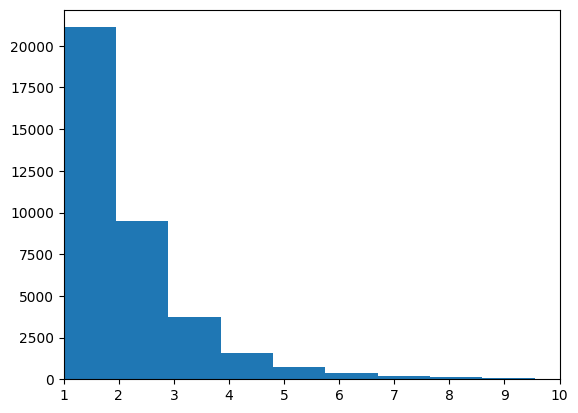

In [10]:
plt.hist(weights,bins=max(weights))
plt.xlim(1,10)
plt.show()

In [11]:
g_und = nx.Graph()

In [12]:
g_und.name = 'Undirected Graph'

In [13]:
g_und.add_nodes_from(airports,bipartite=1)

In [14]:
g_und.add_weighted_edges_from(input_tuple)

In [15]:
nx.is_connected(g_und)

True

In [16]:
degree = dict(g_und.degree())
df = pd.DataFrame()
df['val'] = degree.values()
df['key'] = degree.keys()


In [17]:
cluster_coeff=nx.clustering(g_und)
df['cluster']=cluster_coeff.values()

In [18]:
df.head()

,val,key,cluster
0,7,AAE,0.904762
1,13,AAL,0.807692
2,2,AAN,0.000000
3,3,AAQ,0.666667
4,8,AAR,0.642857


In [19]:
dades = df.groupby(['val']).count()
dades = dades[dades['key']!=0]

In [20]:
index= np.array(dades.index)
n_enllacos = np.array(dades.key)
n_enllacos = list(map(float, n_enllacos))
n_enllacos = np.reshape(n_enllacos, (1, len(n_enllacos)))
n_enllacos = (n_enllacos - n_enllacos.min()) / (n_enllacos.max() - n_enllacos.min())


C:\Users\vdesa\AppData\Local\Temp\ipykernel_27332\897055788.py:8: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(min( n_enllacos[0]),max( n_enllacos[0]))
C:\Users\vdesa\AppData\Local\Temp\ipykernel_27332\897055788.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, max(index))


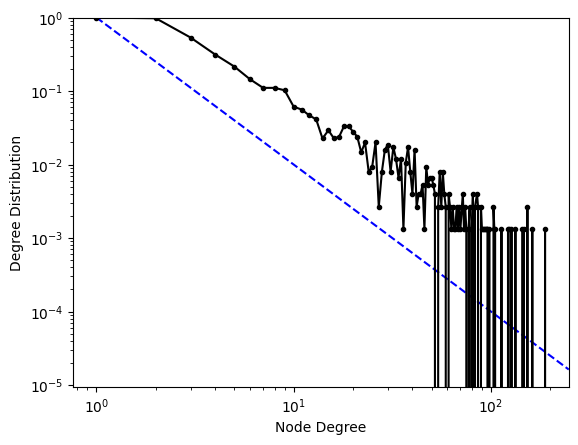

In [21]:
rng = range(len(index))
plt.plot(index, index**-2., "b--")
plt.plot(index,n_enllacos[0],'k.-')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Node Degree')
plt.ylabel('Degree Distribution')
plt.ylim(min( n_enllacos[0]),max( n_enllacos[0]))
plt.xlim(0, max(index))
plt.show()

The following plot depicts the Degree distribution vs the number of Degrees. The degree distribution, 
, provides the probability that a randomly selected node in the network has degree k. The degree distribution has assumed a central role in network theory following the discovery of scale-free networks

As it can be seen the probability of a node to have a high degree is less likely than having a low one, this is, most are highly right-skewed, meaning that a large majority of nodes have low degree but a small number, known as "hubs", have high degree, with more than 1e2 degrees in some cases.



In [22]:
cluster_gr=df.groupby(['val'])['cluster'].mean()

In [23]:
x = np.arange(1,len(cluster_gr.index[1:]))
y = x**-1.

The clustering coefficient captures the degree to which the neighbors of a given node link to each other. For a node i with degree ki the local clustering coefficient is defined as 
 
, where 
 represents the number of links between the 
 neighbors of node i.

Also the theoretical slope approximation as a power low of 
 is also shown in blue, the trend of which does not resemble as much the obtained result in this case.

The average clustering of the network is obtained in the following cell, which is of 0.48. It is the overall level of clustering in a network, and it basically calculates the average of the local clustering coefficients of all the vertices, and therefore informs of how much does the network tend to create local clusters.

In this case it is close to 0.5, which implies that there is about 50% chance that two neighbors of a node are linked.

In [24]:
nx.average_clustering(g_und)

0.48833620245296155

C:\Users\vdesa\AppData\Local\Temp\ipykernel_27332\460363669.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, max(cluster_gr.index[1:]))


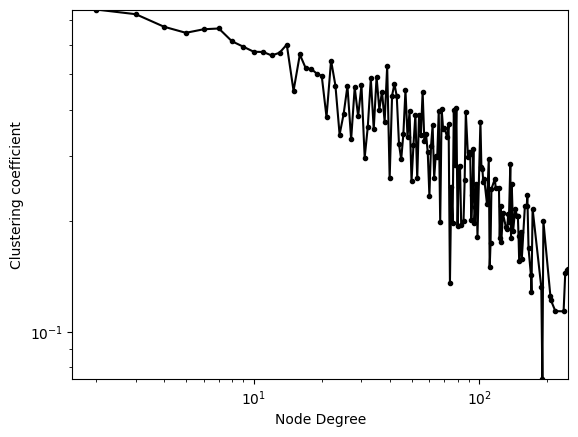

In [25]:
rng = np.arange(len(cluster_gr.index[1:]))
#plt.plot(rng, rng**(-1.), "b--")
plt.plot(cluster_gr.index[1:], cluster_gr.values[1:],'k.-')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Node Degree')
plt.ylabel('Clustering coefficient')
plt.ylim(min( cluster_gr.values[1:]),max( cluster_gr.values[1:]))
plt.xlim(0, max(cluster_gr.index[1:]))
plt.show()

It seems intuitive due to the nature of the network that airports with a very low degree, therefore small amount of flights will tens to create clusters with nearby airports, given that they will be less interconnected with other worldwide airports.

This is what is reflected in the Clustering coefficient vs degree graph, where the clustering coefficient decreases the higher the degree of a node.

In order to travel from one of these low degree nodes, to another cluster several jumps will be needed, thus one should be in the right side nodes of the graph. Major airports however are more connected with other major airports in around the world, and not so much with smaller reagional airports, which might only be connected with some other 2 or 3 airports.
